In [1]:
from transformers import BertModel, BertTokenizer
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained("./bert")
model = BertModel.from_pretrained("./bert").to(device)
def bert_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    return output.last_hidden_state.cpu().detach()

In [2]:
import pandas


train_pd = pandas.read_csv("./data/train.csv")
test_pd = pandas.read_csv("./data/test.csv")
train_X_pos, train_X_neg = [], []
test_X = []
for i in range(train_pd.shape[0]):
    line = train_pd.iloc[i]
    bert_output = bert_embedding(line["text"])
    if line["target"] == 1:
        train_X_pos.append(bert_output)
    elif line["target"] == 0:
        train_X_neg.append(bert_output)
for i in range(test_pd.shape[0]):
    line = test_pd.iloc[i]
    bert_output = bert_embedding(line["text"])
    test_X.append(bert_output)

In [6]:
import torch


class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bilstm = torch.nn.LSTM(768, 32, batch_first=True, bidirectional=False)
        self.attention = torch.nn.MultiheadAttention(32, 1, batch_first=True)
        self.fc = torch.nn.Linear(32, 2)

    def forward(self, x):
        x, _ = self.bilstm(x)
        x, _ = self.attention(x, x, x)
        x = x[:, 0, :]
        x = self.fc(x)
        return x

In [4]:
import random


def align(X, max_length=32):
    if X.shape[0] < max_length:
        X = torch.concat([X, torch.zeros((max_length - X.shape[0], X.shape[1]))], dim=0)
    return X[:max_length, :]

random.seed(1)
select = [(align(X[0]), 1) for X in train_X_pos] + [(align(X[0]), 0) for X in train_X_neg]
random.shuffle(select)
train_set = select[:]
val_set = select[int(0.9 * len(select)):]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

In [8]:
decoder = Decoder().to(device)
epochs = 50
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss().to(device)
train_acc=[]
val_acc = []
for epoch in range(epochs):
    decoder.train()
    for data, label in train_loader:
        data, label = data.to(device), label.to(device)
        output = decoder(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    decoder.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            output = torch.argmax(decoder(data), dim=1)
            correct += torch.sum(output == label)
            total += data.size(0)

    train_acc.append(correct / total)
    print(f"epoch: {epoch}, train acc: {correct / total}")
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)
            output = torch.argmax(decoder(data), dim=1)
            correct += torch.sum(output == label)
            total += data.size(0)
    val_acc.append(correct / total)
    print(f"epoch: {epoch}, val acc: {correct / total}")


epoch: 0, train acc: 20.020973954571396
epoch: 0, val acc: 20.090340009911376
epoch: 1, train acc: 20.02751721121006
epoch: 1, val acc: 20.162199440953387
epoch: 2, train acc: 20.212777972616337
epoch: 2, val acc: 20.207116938196553
epoch: 3, train acc: 21.020919556577432
epoch: 3, val acc: 20.274345402953386
epoch: 4, train acc: 22.242013633363864
epoch: 4, val acc: 20.336739629336265
epoch: 5, train acc: 23.149401863491143
epoch: 5, val acc: 20.57190129617793
epoch: 6, train acc: 23.16066009033746
epoch: 6, val acc: 21.06254231647925
epoch: 7, train acc: 23.82278970363749
epoch: 7, val acc: 21.403889030445914
epoch: 8, train acc: 24.279488078299817
epoch: 8, val acc: 21.437795469099377
epoch: 9, train acc: 24.7255147980822
epoch: 9, val acc: 22.873846143360336
epoch: 10, train acc: 24.731357391576672
epoch: 10, val acc: 23.006155651888992
epoch: 11, train acc: 25.678305154373767
epoch: 11, val acc: 24.4127894977914
epoch: 12, train acc: 26.678099654406477
epoch: 12, val acc: 24.55411

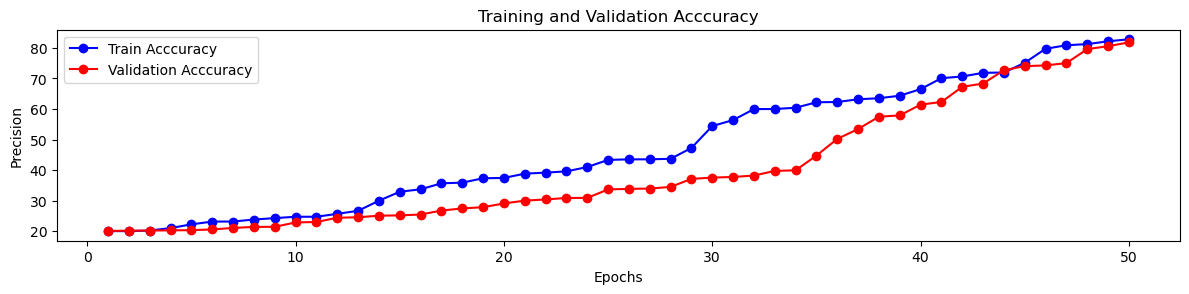

In [11]:
import matplotlib.pyplot as plt
epochs2 = range(1, 50 + 1)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(epochs2, train_acc, 'bo-', label='Train Acccuracy')
plt.plot(epochs2, val_acc, 'ro-', label='Validation Acccuracy')
plt.title('Training and Validation Acccuracy')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()


plt.tight_layout()
plt.show()
